In [9]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

import itertools

from py_wake.deficit_models import EddyViscosityDeficitModel, EddyViscosityModel, BastankhahGaussianDeficit
from py_wake import HorizontalGrid

# turbines and sites
from py_wake.site import XRSite, UniformWeibullSite, UniformSite
from py_wake.site._site import Site
from py_wake.site.shear import PowerShear
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.generic_wind_turbines import GenericWindTurbine
from py_wake.examples.data.hornsrev1 import Hornsrev1Site, V80
from py_wake.examples.data.iea37 import IEA37Site, IEA37_WindTurbines
from py_wake.examples.data.ParqueFicticio import ParqueFicticioSite
from py_wake.examples.data.dtu10mw import DTU10MW

from py_wake.wind_farm_models.wind_farm_model import SimulationResult
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.wind_turbines import WindTurbine, WindTurbines
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular

In [10]:
# parameters for data generation
TURBINE_X = [0]
TURBINE_Y = [0]
GRID_STEP_DIAM_FACTOR = 1/16
#WS_RANGE = range(3, 26) # by default, 3-25 m/s in bins of 1 m/s TODO change to one random value (?)
WD_RANGE = 270 # the wind turbine's yaw angle is always adjusted according to the wind direction, thus it is probably useless to generate data with more wind directions
#WD_RANGE = range(0, 360) # (by default, 0-360° in bins of 1°)

# filepath
DATAFRAME_FILEPATH = f"data/wake_dataframe_{GRID_STEP_DIAM_FACTOR}diam.csv"

# Preparation of the parameters for the data generation

## Site (to set turbulence intensity TI and...?)
For a given position, reference wind speed (WSref) and wind direction (WDref), Site provides the local wind condition in terms of wind speed (WS), wind direction (WD), turbulence intensity (TI) and the probability of each combination of wind direction and wind speed. Furthermore, Site is responsible for calculating the down-wind, cross-wind and vertical distance between wind turbines (which in non-flat terrain is different from the straight-line distances).

In [11]:
# TODO decide what site to use (custom or predefined) and see how to set other parameters (P, shear, dataset, etc. etc.)
def OLD_get_sites(turbulence_intensity : float) -> list[XRSite]:

    # assert 0 <= turbulence_intensity <= 1 #TODO if it is a percentage, this is correct

    custom_site = UniformWeibullSite(
        p_wd = [.20,.25,.35,.25],                         # sector frequencies
        a = [9.176929,  9.782334,  9.531809,  9.909545],  # Weibull scale parameter
        k = [2.392578, 2.447266, 2.412109, 2.591797],     # Weibull shape parameter
        ti = turbulence_intensity,                        # turbulence intensity, optional
    )
    '''
    not working
    custom_site = XRSite(
        ds=xr.Dataset(data_vars={'WS': range(3, 26), 'P': ('wd', [1/360] * len(range(0, 360))), 'TI': 0.25},
                    coords={'wd': range(0, 360)}),
        shear=PowerShear(h_ref=100, alpha=.2)
    )
    '''
    custom_site = XRSite(ds=xr.Dataset(data_vars={'WS': 5, 'P': 1, 'TI': 0.1}))
                    #coords={'wd': range(0, 360)}
    return [IEA37Site(ti=turbulence_intensity)] #, Hornsrev1Site(ti=turbulence_intensity), custom_site] #ParqueFicticioSite() not having ti as an argument

def get_site(turbulence_intensity: float, wind_speed: int) -> XRSite:
    #return XRSite(ds=xr.Dataset(data_vars={'WS': WS_RANGE, 'P': 1, 'TI': turbulence_intensity}, coords={'wd': WD_RANGE}))
    return UniformSite(ti=turbulence_intensity, ws=wind_speed)

## Turbine (to set thrust coefficient CT)

For a given wind turbine type and effective wind speed (WSeff), the WindTurbine object provides the power and thrust coefficient (CT), as well as the wind turbine hub height (H) and diameter (D).

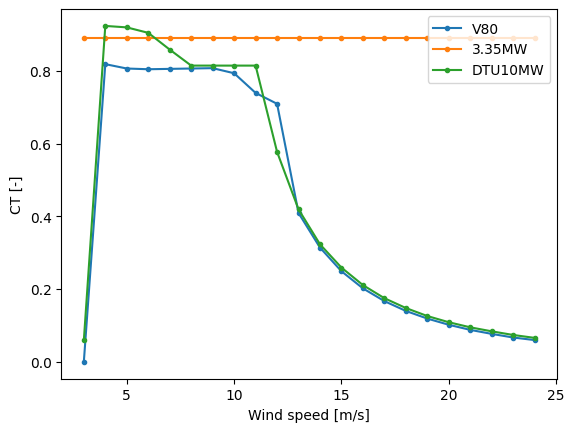

In [12]:
# TODO decide what turbine(s) to use (custom or predefined) and see how to set other parameters

def OLD_get_wind_turbines() -> list[WindTurbine]:
    '''option 1 (obsolete)'''
    # you need 3 parameters for a custom turbine: u (ws_values), power and ct curves
    # (see how powerCtFunction is initialized in the pre-defined turbines)
    u: list[int] = [5, 10, 15, 20, 25]
    power: list[float] = [1000, 1000, 1000, 1000, 1000]
    ct: list[float] = [0.99, 0.5, 0.75, .3, 0.9]
    custom_turbine = WindTurbine(name="custom", diameter=100, hub_height=100, powerCtFunction=PowerCtTabular(u, power,'kW', ct))

    '''implemented options (to delete)'''
    return [V80(), IEA37_WindTurbines(), DTU10MW()]  #, custom_turbine] 

def get_wind_turbine(ct: float) -> WindTurbine:
    # diameter, hub height and power norm taken from IEA37 as these params affect the simulation
    # TODO update values or try different ones?
    diameter = 198
    hub_height = 119
    power_norm = 10000
    return GenericWindTurbine(name="AinslieTurbine",
                              diameter=diameter, hub_height=hub_height, power_norm=power_norm,
                              constant_ct=ct)

def plot_ct_curves(custom_turbine = None) -> None:
    # plot Ct curve
    plt.xlabel('Wind speed [m/s]')
    plt.ylabel('CT [-]')

    l = [V80(), IEA37_WindTurbines(), DTU10MW()]
    if custom_turbine:
        l.append(custom_turbine)
    wts = WindTurbines.from_WindTurbine_lst(l)
    ws = np.arange(3,25)
    for t in wts.types():
        plt.plot(ws, wts.ct(ws, type=t),'.-', label=wts.name(t))
    plt.legend(loc=1)

plot_ct_curves()

## Discretization

In [13]:
def get_discretized_grid(diameter: int) -> HorizontalGrid: #TODO decide whether this function should depend on the diameter or not
    # TODO check the discretization (see Javier thesis, appendix B in particular), my current reasonings:
    # for the minimum length is diameter*2 to skip the near-wake, but TODO this depends also on the wind direction
    #   i.e. if the wind direction is within the whole range (0, 360), there will be some warnings of near-wake region even if I set diameter*2
    # for the maximum length is diameter*50 (i.e. DEFAULT_MAXIMUM_WAKE_DISTANCE in PyWake EddyViscosity definition) ✅
    # for the third value (?), Javier's thesis tries different values (diameter/2, diameter/4, ..., diameter/16)
    
    # if the wind direction remains stable at 270 (as it seems), it is useless to put big bounderies for y
    #TODO see also datadriven wind turbine wake modelling via probabilistic ML (e.g. Fig. 3) to set these parameters
    
    x_range = np.arange(diameter*2, diameter*50, diameter*GRID_STEP_DIAM_FACTOR)
    y_range = np.arange(-diameter, diameter, diameter*GRID_STEP_DIAM_FACTOR)
    #print(f"Shape of the grid: {len(x_range)}x{len(y_range)}")
    return HorizontalGrid(x = x_range, y = y_range)

# 

In [14]:
def generate_wake_dataframe(sim_res: SimulationResult, grid: HorizontalGrid, wind_speed: float, wind_turbine: WindTurbine) -> pd.DataFrame:
    """
    #TODO change comment
    The dataframe has the input variables as indexes and the output variables (wake, TI and P) as columns
    """
    # the following method call (flow_map) creates a warning for near-wake
    flow_map = xr.Dataset(sim_res.flow_map(grid=grid,
                                wd=WD_RANGE,
                                ws=wind_speed))
    
    # removing h, wd and ws
    h = flow_map['h'].item()
    flow_map = flow_map\
        .sel(h=h)\
        .sel(wd=270)\
        .sel(ws=wind_speed)
    flow_map = flow_map.drop_vars(["h", "wd", "ws", "WD", "TI", "P"])

    TI = sim_res.TI.item()
    flow_map["TI"] = xr.DataArray([TI], dims="TI")
    # ct is now correlated to the wind speed (which would make it useless for the prediction) but it should depend also on the turbine
    ct = wind_turbine.ct(ws=wind_speed) #TODO
    flow_map["ct"] = xr.DataArray([ct], dims="ct") #TODO putting this as a dimension is wrong and creates problems in the xarray (this is why dataframe)

    diameter = wind_turbine.diameter().item()

    #TODO sistema codice di seguito
    df = flow_map.to_dataframe()
    df["wind_deficit"] = 1 - df["WS_eff"]/df["WS"]
    # scaling x and y according to the diameter
    df.reset_index(inplace=True)
    df["x/D"] = df["x"] / diameter
    df["y/D"] = df["y"] / diameter
    df.drop(["x", "y"], axis=1, inplace=True)
    df.set_index(["x/D", "y/D", "TI", "ct"], inplace=True)

    return df

def plot_wake_from_flow_map(flow_map):
    plt.figure()
    flow_map.plot_wake_map()
    plt.xlabel('x [m]')
    plt.ylabel('y [m]')
    plt.title('Wake map')

def plot_wake_from_xr_dataset(ds):
    ds = xr.Dataset.from_dataframe(ds.to_dataframe()) #TODO useless
    ds.WS_eff.plot()

# Actual data generation

In [ ]:
TIs = np.arange(0, 1, 0.01) #TODO check which right values
CTs = np.arange(0, 1, 0.01) #TODO check range which right values
WIND_SPEED = 12

sites = [get_site(turbulence_intensity=ti, wind_speed=WIND_SPEED) for ti in TIs]
wind_turbines = [get_wind_turbine(ct=ct) for ct in CTs]

dataframes = list()
for site, wind_turbine in itertools.product(sites, wind_turbines):
    # single wake model
    ainslie_model = EddyViscosityModel(site, wind_turbine)

    diameter: int = wind_turbine.diameter().item() #TODO this needs to be used for scaling distances and also to exclude near-wake region
    horizontal_grid = get_discretized_grid(diameter)

    sim_res: SimulationResult = ainslie_model(
        TURBINE_X, TURBINE_Y,        # wind turbine positions (setting also wt domain, i.e. the number of turbines)
        h=None,                      # wind turbine heights (defaults to the heights defined in windTurbines)
        type=0,                      # Wind turbine types
        wd=WD_RANGE,                 # Wind direction (None for default -> 0-360° in bins of 1°)
        ws=WIND_SPEED,                 # Wind speed (None for default -> 3-25 m/s in bins of 1 m/s)
        #TI = 0.15 # DO NOT SET TI HERE, this is not taken into account when calling flow_map (TI depends on the chosen site)
        #TODO yaw = 0 prova putting this parameter
    ) # type: ignore
    
    #for wind_speed in WS_RANGE:
        #TODO find the final solution for the data structure for input and output variables
        #input_tensor = torch.FloatTensor([wind_speed, ct, TI]) #TODO add other input features
        #WS_eff_output, TI_eff_output = generate_wake_fields(sim_res, horizontal_grid, wind_speed=wind_speed, with_plot=True)
    df = generate_wake_dataframe(sim_res, horizontal_grid, wind_speed=WIND_SPEED, wind_turbine=wind_turbine) #TODO wind_speed value
        #TODO add control to make sure that I do not add the same input variables twice
    #dataframes.append(df)


final_df = pd.concat(dataframes)
final_df

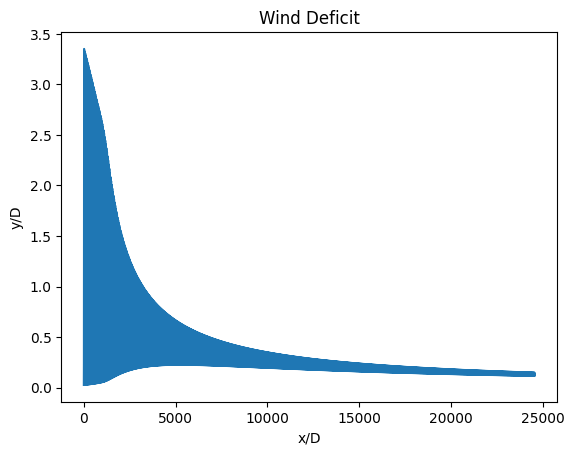

In [ ]:
import matplotlib.pyplot as plt

# create a scatter plot with wind_deficit as color
df = final_df.reset_index()
ax = df["wind_deficit"].plot(x="x/D", y="y/D")

# set axis labels and title
ax.set_xlabel("x/D")
ax.set_ylabel("y/D")
ax.set_title("Wind Deficit")
plt.show()

In [ ]:
"""attempt with deficit model to be deleted

from py_wake.deficit_models import BastankhahGaussianDeficit
from py_wake.turbulence_models.quarton_and_ainslie import (
    ModifiedQuartonAndAinslieTurbulenceModel,
)

a = EddyViscosityDeficitModel()
b = BastankhahGaussianDeficit()
wfm = PropagateDownwind(site, wind_turbine, wake_deficitModel=a, turbulenceModel=ModifiedQuartonAndAinslieTurbulenceModel())
print(a)
print(b)
prova = wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(horizontal_grid)
prova.plot(prova.ws - prova.WS_eff, clabel='Deficit [m/s]', levels=levels, cmap=cmap, normalize_with=D)
setup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",
            xlim=[prova.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis='auto')
"""

'attempt with deficit model to be deleted\n\nfrom py_wake.deficit_models import BastankhahGaussianDeficit\nfrom py_wake.turbulence_models.quarton_and_ainslie import (\n    ModifiedQuartonAndAinslieTurbulenceModel,\n)\n\na = EddyViscosityDeficitModel()\nb = BastankhahGaussianDeficit()\nwfm = PropagateDownwind(site, wind_turbine, wake_deficitModel=a, turbulenceModel=ModifiedQuartonAndAinslieTurbulenceModel())\nprint(a)\nprint(b)\nprova = wfm(x=[0], y=[0], wd=270, ws=10, yaw=0).flow_map(horizontal_grid)\nprova.plot(prova.ws - prova.WS_eff, clabel=\'Deficit [m/s]\', levels=levels, cmap=cmap, normalize_with=D)\nsetup_plot(grid=False, ylabel="Crosswind distance [y/D]", xlabel= "Downwind distance [x/D]",\n            xlim=[prova.x.min()/D, fm.x.max()/D], ylim=[fm.y.min()/D, fm.y.max()/D], axis=\'auto\')\n'

In [ ]:
#final_df.to_csv(DATAFRAME_FILEPATH)